In [1]:
# Instal·lació de dependències (si és necessari)
%pip install torch pandas numpy matplotlib scikit-learn seaborn ucimlrepo shap xgboost scipy

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import shap
import xgboost as xgb
import warnings
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, brier_score_loss
from torch.utils.data import DataLoader, TensorDataset
from scipy.spatial.distance import cosine

# Configuració global
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cpu") # Usem CPU per demostrar eficiència en commodity hardware
print(f"Entorn preparat. Dispositiu: {device}")

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Entorn preparat. Dispositiu: cpu


/Users/eloi.garcia/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("Descarregant UCI Credit Card Dataset (ID: 350)...")
dataset = fetch_ucirepo(id=350)

# Dades originals (Pandas) per mantenir noms de columnes
X_raw = dataset.data.features
y_raw = dataset.data.targets

print(f"Variables: {list(X_raw.columns)}")

# Conversió inicial a tipus numèric (float32) per evitar problemes
X_np = X_raw.values.astype(np.float32)
y_np = y_raw.values.astype(np.float32).ravel()

# Split Train/Test (Estratificat)
# Guardem X_test com a dades crues per a l'anàlisi de Fairness
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_np, y_np, test_size=0.2, random_state=42, stratify=y_np
)

# Escalat (Fit només a Train)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

# Creació de DataLoaders de PyTorch
train_ds = TensorDataset(torch.tensor(X_train_scaled), torch.tensor(y_train).float().unsqueeze(1))
test_ds = TensorDataset(torch.tensor(X_test_scaled), torch.tensor(y_test).float().unsqueeze(1))

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader_rt = DataLoader(test_ds, batch_size=1, shuffle=False) # Batch 1 per simulació real-time

print(f"Dades preparades. Train: {X_train_scaled.shape}, Test: {X_test_scaled.shape}")

Descarregant UCI Credit Card Dataset (ID: 350)...
Variables: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23']
Dades preparades. Train: (24000, 23), Test: (6000, 23)


In [3]:
class FeatureAttentionLayer(nn.Module):
    """Calcula la importància global (pesos d'atenció)"""
    def __init__(self, input_dim):
        super().__init__()
        self.attention_weights = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.Tanh(),
            nn.Linear(input_dim, input_dim),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        attn_scores = self.attention_weights(x)
        return x * attn_scores, attn_scores

class RTXFairModel(nn.Module):
    def __init__(self, input_dim, beta=0.5):
        super().__init__()
        self.input_dim = input_dim
        self.beta = beta

        # Mòdul d'Atenció
        self.attn_layer = FeatureAttentionLayer(input_dim)

        # Backbone (MLP Predictor)
        self.backbone = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Forward pass simple (per entrenament i predicció)
        weighted_x, _ = self.attn_layer(x)
        return self.backbone(weighted_x)

    def explain(self, x, n_samples=5, std=0.1):
        """
        Versió millorada: Smooth Fast-IG + Attention
        Calcula el gradient promig de 'n_samples' amb soroll per eliminar inestabilitat.
        """
        # 1. Forward i Atenció (només una vegada, amb l'input original)
        # Això manté la part d'atenció estable
        weighted_x, attn_scores = self.attn_layer(x)
        prediction = self.backbone(weighted_x)

        # 2. Smooth Fast-IG (Gradients suavitzats)
        # Repliquem l'input N vegades i afegim soroll
        # x: [1, features] -> x_rep: [n, features]
        x_rep = x.repeat(n_samples, 1)
        noise = torch.randn_like(x_rep) * std
        x_noisy = x_rep + noise
        x_noisy.requires_grad_()
        
        # Forward dels inputs sorollosos
        # (Com que és un batch petit, és molt ràpid en paral·lel)
        w_noisy, _ = self.attn_layer(x_noisy)
        pred_noisy = self.backbone(w_noisy)
        
        # Calculem gradients per a tot el batch de cop
        grads = torch.autograd.grad(outputs=pred_noisy, inputs=x_noisy,
                                    grad_outputs=torch.ones_like(pred_noisy),
                                    create_graph=False, retain_graph=False)[0]
        
        # Input * Gradient (Aproximació IG)
        # Fem la mitjana dels N gradients
        avg_grad = torch.mean(x_noisy * grads, dim=0, keepdim=True)
        
        # 3. Normalització L1 (Millor alineació amb Softmax)
        # Ara sumaran 1 (en valor absolut), com l'atenció
        norm_ig = avg_grad / (torch.sum(torch.abs(avg_grad), dim=1, keepdim=True) + 1e-9)

        # 4. Fusió
        explanation = self.beta * norm_ig + (1 - self.beta) * attn_scores
        
        return prediction.detach(), explanation.detach()

model = RTXFairModel(input_dim=X_train_scaled.shape[1])
print("Model inicialitzat.")

Model inicialitzat.


In [4]:
criterion = nn.BCELoss()
# Learning rate baix per estabilitat
optimizer = optim.Adam(model.parameters(), lr=0.0005) 
epochs = 30 

print("Iniciant entrenament robust...")
model.train()

history_loss = []

for epoch in range(epochs):
    epoch_loss = 0
    correct = 0
    total = 0
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        
        # 1. Forward manual per obtenir els scores d'atenció
        weighted_x, attn_scores = model.attn_layer(batch_X)
        outputs = model.backbone(weighted_x)
        
        # 2. Loss Principal (Predicció)
        bce_loss = criterion(outputs, batch_y)
        
        # 3. REGULARITZACIÓ D'ENTROPIA
        # Penalitza distribucions planes (1/N) i força a triar variables
        entropy_loss = -torch.mean(torch.sum(attn_scores * torch.log(attn_scores + 1e-9), dim=1))
        
        # Pes petit (0.01) per l'entropia
        loss = bce_loss + 0.01 * entropy_loss
        
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        
        # Càlcul d'accuracy
        predicted = (outputs > 0.5).float()
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

    avg_loss = epoch_loss/len(train_loader)
    history_loss.append(avg_loss)
    
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Acc: {100*correct/total:.2f}%")

# Avaluació Final (AUC)
model.eval()
with torch.no_grad():
    y_pred = model(torch.tensor(X_test_scaled)).numpy()
auc = roc_auc_score(y_test, y_pred)
print(f"\nEntrenament finalitzat. AUC Test: {auc:.4f}")

Iniciant entrenament robust...
Epoch 5/30 | Loss: 0.4597 | Acc: 81.54%
Epoch 10/30 | Loss: 0.4470 | Acc: 82.03%
Epoch 15/30 | Loss: 0.4419 | Acc: 82.14%
Epoch 20/30 | Loss: 0.4383 | Acc: 82.16%
Epoch 25/30 | Loss: 0.4363 | Acc: 82.19%
Epoch 30/30 | Loss: 0.4345 | Acc: 82.24%

Entrenament finalitzat. AUC Test: 0.7580


In [5]:
latencies = []
model.eval()

print("Mesurant latència (10000 inferències)...")

# Bucle de test en mode 'single batch' (simulant temps real)
for i, (bx, _) in enumerate(test_loader_rt):
    if i >= 10000: break
    
    start = time.perf_counter()
    # Activem gradients només per al càlcul de l'explicació (dins .explain)
    with torch.enable_grad():
        _ = model.explain(bx)
    end = time.perf_counter()
    
    latencies.append((end - start) * 1000) # a ms

latencies = np.array(latencies)
p99_val = np.percentile(latencies, 99)

print(f"Latència Mitjana: {np.mean(latencies):.2f} ms")
print(f"Latència P99    : {p99_val:.2f} ms")
print(f"Objectiu Tesi   : < 25.00 ms -> {'ASSOLIT' if p99_val < 25 else 'NO ASSOLIT'}")

Mesurant latència (10000 inferències)...
Latència Mitjana: 0.23 ms
Latència P99    : 0.33 ms
Objectiu Tesi   : < 25.00 ms -> ASSOLIT


/var/folders/9m/6pdr6pzx3m52r2xnhgjyk15h0000gn/T/ipykernel_23030/3917713233.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(feat_names, rotation=90, fontsize=8)
/var/folders/9m/6pdr6pzx3m52r2xnhgjyk15h0000gn/T/ipykernel_23030/3917713233.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(feat_names, rotation=90, fontsize=8)
/var/folders/9m/6pdr6pzx3m52r2xnhgjyk15h0000gn/T/ipykernel_23030/3917713233.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(feat_names, rotation=90, fontsize=8)
/var/folders/9m/6pdr6pzx3m52r2xnhgjyk15h0000gn/T/ipykernel_23030/3917713233.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. afte

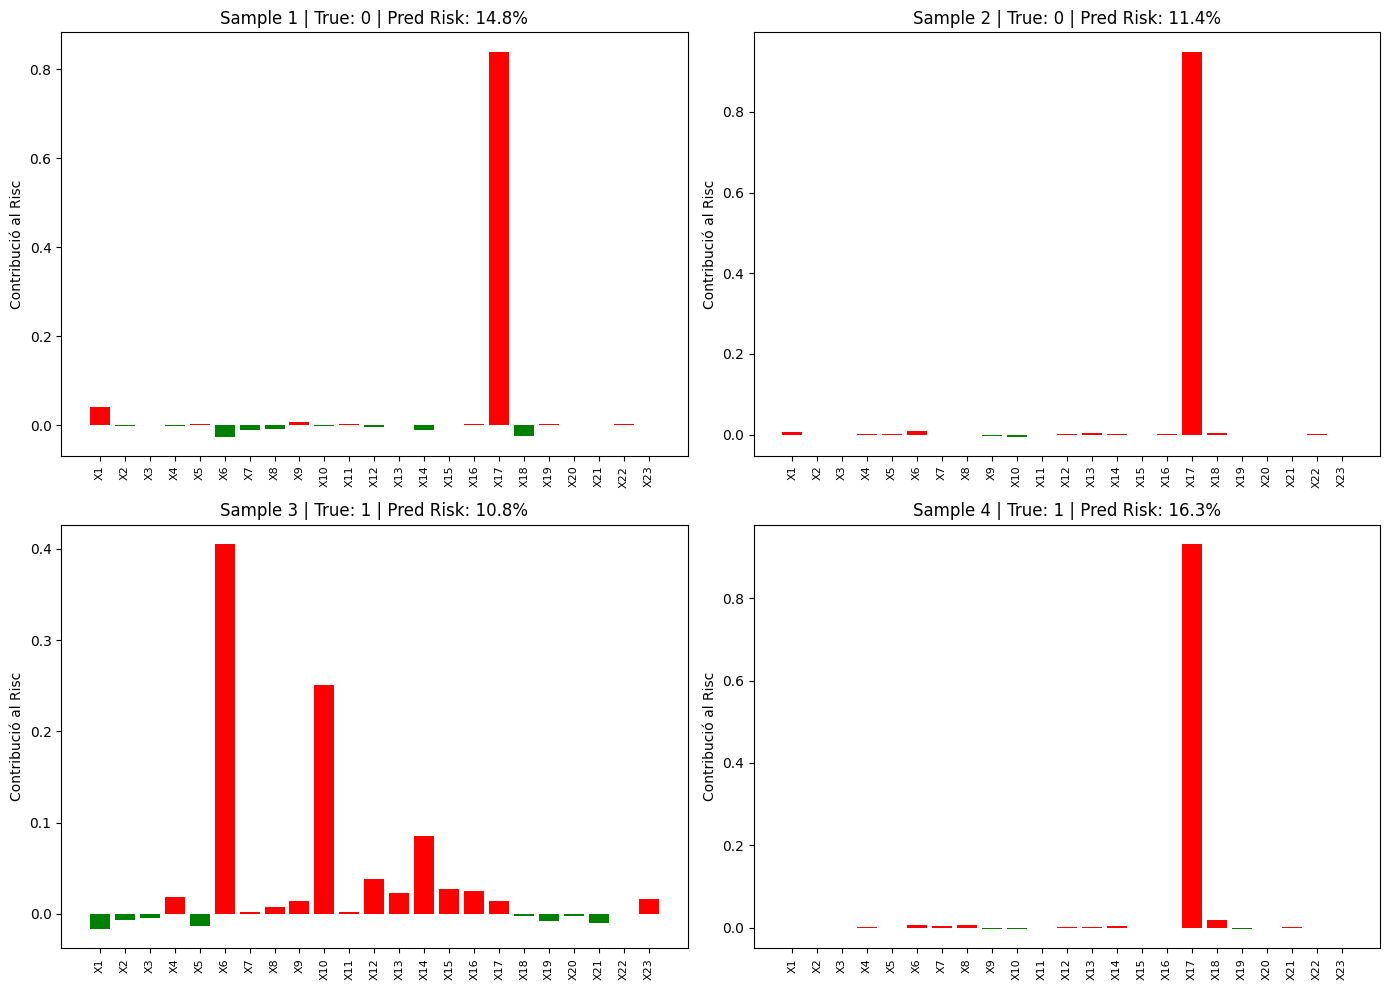

In [6]:
# Agafem dos exemples amb label=1 i dos amb label=0 del test set
model.eval()

indices_class_0 = np.where(y_test == 0)[0][:2]
indices_class_1 = np.where(y_test == 1)[0][:2]
selected_indices = np.concatenate([indices_class_0, indices_class_1])

feat_names = list(X_raw.columns)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, sample_idx in enumerate(selected_indices):
    example_input = torch.tensor(X_test_scaled[sample_idx:sample_idx+1]).float()
    pred, expl = model.explain(example_input)
    
    vals = expl.flatten().numpy()
    colors = ['red' if x > 0 else 'green' for x in vals]
    true_label = int(y_test[sample_idx])
    
    axes[idx].bar(feat_names, vals, color=colors)
    axes[idx].set_xticklabels(feat_names, rotation=90, fontsize=8)
    axes[idx].set_title(f"Sample {idx+1} | True: {true_label} | Pred Risk: {pred.item():.1%}")
    axes[idx].set_ylabel("Contribució al Risc")

plt.tight_layout()
plt.show()

In [7]:
def optimize_beta(model, X_val, explainer_shap, k=3):
    print("Iniciant Optimització de Beta...")
    
    # 1. Preparació (50 mostres)
    X_sample = X_val[:50]
    X_tensor = torch.tensor(X_sample).float()
    
    # 2. Ground Truth (SHAP) - Sense Warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        shap_raw = explainer_shap.shap_values(X_sample, nsamples=100, silent=True)
    
    # Normalització dimensions SHAP
    if isinstance(shap_raw, list): shap_vals = shap_raw[0]
    else: shap_vals = shap_raw
    shap_vals = np.array(shap_vals)
    if len(shap_vals.shape) == 3: shap_vals = shap_vals.squeeze() # Aplanar (N, Feats, 1) -> (N, Feats)
    
    best_beta = 0.5
    best_score = -1
    
    print(f"\n{'Beta':<6} | {'Top-3 Match (vs SHAP)':<25}")
    print("-" * 35)

    # 3. Grid Search
    for beta in np.arange(0,1,0.001):
        model.beta = beta
        matches = 0
        valid_samples = 0
        
        for i in range(len(X_sample)):
            # Vectors 1D
            s_vec = shap_vals[i].flatten()
            _, expl = model.explain(X_tensor[i:i+1])
            rt_vec = expl.numpy().flatten()
            
            if np.all(s_vec == 0) or np.all(rt_vec == 0): continue
            
            # Top-K Índexs
            top_shap = np.argsort(np.abs(s_vec))[-k:]
            top_rt = np.argsort(np.abs(rt_vec))[-k:]
            
            # Coincidència
            matches += len(set(top_shap).intersection(set(top_rt))) / k
            valid_samples += 1
            
        score = matches / valid_samples if valid_samples > 0 else 0
        print(f"{beta:<6.3f} | {score:.2%}")
        
        if score > best_score:
            best_score = score
            best_beta = beta
            
    print("-" * 35)
    print(f"Beta Òptima: {best_beta} (Score: {best_score:.2%})")
    model.beta = best_beta
    return best_beta, best_score

# --- SETUP SHAP ROBUST ---
print("Inicialitzant SHAP...")
# Usem shap.sample en lloc de kmeans per evitar errors de divisió per zero
background = shap.sample(X_train_scaled, 100) 
predict_fn = lambda x: model(torch.tensor(x).float()).detach().numpy()
explainer = shap.KernelExplainer(predict_fn, background)

optimal_beta, topk_fidelity = optimize_beta(model, X_test_scaled, explainer)

Inicialitzant SHAP...
Iniciant Optimització de Beta...

Beta   | Top-3 Match (vs SHAP)    
-----------------------------------
0.000  | 60.00%
0.001  | 60.00%
0.002  | 60.00%
0.003  | 60.00%
0.004  | 60.00%
0.005  | 60.00%
0.006  | 60.00%
0.007  | 59.33%
0.008  | 59.33%
0.009  | 59.33%
0.010  | 59.33%
0.011  | 59.33%
0.012  | 59.33%
0.013  | 59.33%
0.014  | 59.33%
0.015  | 58.67%
0.016  | 58.67%
0.017  | 58.00%
0.018  | 58.67%
0.019  | 58.67%
0.020  | 58.00%
0.021  | 58.00%
0.022  | 58.00%
0.023  | 58.00%
0.024  | 58.00%
0.025  | 57.33%
0.026  | 57.33%
0.027  | 57.33%
0.028  | 57.33%
0.029  | 57.33%
0.030  | 57.33%
0.031  | 57.33%
0.032  | 57.33%
0.033  | 57.33%
0.034  | 57.33%
0.035  | 57.33%
0.036  | 58.00%
0.037  | 58.00%
0.038  | 57.33%
0.039  | 58.00%
0.040  | 58.00%
0.041  | 58.67%
0.042  | 58.67%
0.043  | 58.67%
0.044  | 57.33%
0.045  | 57.33%
0.046  | 58.67%
0.047  | 57.33%
0.048  | 58.67%
0.049  | 58.67%
0.050  | 57.33%
0.051  | 58.00%
0.052  | 57.33%
0.053  | 57.33%
0.054  | 

In [8]:
def analyze_comprehensive_fairness(model, X_raw_pandas, X_test_raw, scaler):
    print("\n" + "="*50)
    print("   MONITORATGE DE FAIRNESS (X2, X3, X4)")
    print("="*50)
    
    # Prediccions massives
    X_scaled = scaler.transform(X_test_raw)
    tensor_X = torch.tensor(X_scaled).float()
    
    model.eval()
    with torch.no_grad():
        probs = model(tensor_X).numpy()
        decisions = (probs > 0.5).astype(int).flatten()
        
    # Mapeig d'etiquetes (UCI Dataset Standard)
    labels_map = {
        'X2': {1: 'Home', 2: 'Dona'},
        'X3': {1: 'Postgrau', 2: 'Universitat', 3: 'Secundària', 4: 'Altres'},
        'X4': {1: 'Casat', 2: 'Solter', 3: 'Altres'}
    }
    
    # Variables d'interès (Noms tècnics del dataset)
    target_cols = ['X2', 'X3', 'X4'] 
    
    for col_name in target_cols:
        if col_name in X_raw_pandas.columns:
            col_idx = list(X_raw_pandas.columns).index(col_name)
            col_data = X_test_raw[:, col_idx] # Dades crues
            
            print(f"\n--- Variable: {col_name} ---")
            rates = {}
            
            for val in np.unique(col_data):
                # Filtres de neteja
                if col_name == 'X3' and val not in [1, 2, 3, 4]: continue
                if col_name == 'X4' and val not in [1, 2, 3]: continue
                
                mask = (col_data == val)
                if np.sum(mask) < 20: continue 
                
                # Taxa Aprovació (% de 0s)
                approval_rate = np.mean(decisions[mask] == 0)
                label = labels_map.get(col_name, {}).get(val, str(val))
                rates[label] = approval_rate
                
                print(f"   - {label:<12}: {approval_rate:.2%} (n={np.sum(mask)})")
            
            if rates:
                gap = max(rates.values()) - min(rates.values())
                status = "ALERTA (>10%)" if gap > 0.10 else ("Correcte" if gap < 0.05 else "Alerta (>5%)")
                if status == "Correcte":
                    print(f"   >> Max Gap: {gap:.2%}  \033[92m{status}\033[0m")
                elif status == "Alerta (>5%)":
                    print(f"   >> Max Gap: {gap:.2%}  \033[93m{status}\033[0m")
                else:
                    print(f"   >> Max Gap: {gap:.2%}  \033[91m{status}\033[0m")

# Execució
analyze_comprehensive_fairness(model, X_raw, X_test_raw, scaler)


   MONITORATGE DE FAIRNESS (X2, X3, X4)

--- Variable: X2 ---
   - Home        : 87.55% (n=2402)
   - Dona        : 88.47% (n=3598)
   >> Max Gap: 0.91%  Correcte

--- Variable: X3 ---
   - Postgrau    : 91.46% (n=2130)
   - Universitat : 86.16% (n=2774)
   - Secundària  : 85.90% (n=1014)
   - Altres      : 92.31% (n=26)
   >> Max Gap: 6.41%  Alerta (>5%)

--- Variable: X4 ---
   - Casat       : 87.71% (n=2767)
   - Solter      : 88.35% (n=3158)
   - Altres      : 92.65% (n=68)
   >> Max Gap: 4.93%  Correcte


Generant Gràfic de Validació Global...


/Users/eloi.garcia/Library/Python/3.9/lib/python/site-packages/shap/explainers/_kernel.py:706: RuntimeWarning: divide by zero encountered in matmul
  w = np.linalg.solve(X.T @ WX, WX.T @ y)
/Users/eloi.garcia/Library/Python/3.9/lib/python/site-packages/shap/explainers/_kernel.py:706: RuntimeWarning: overflow encountered in matmul
  w = np.linalg.solve(X.T @ WX, WX.T @ y)
/Users/eloi.garcia/Library/Python/3.9/lib/python/site-packages/shap/explainers/_kernel.py:706: RuntimeWarning: invalid value encountered in matmul
  w = np.linalg.solve(X.T @ WX, WX.T @ y)


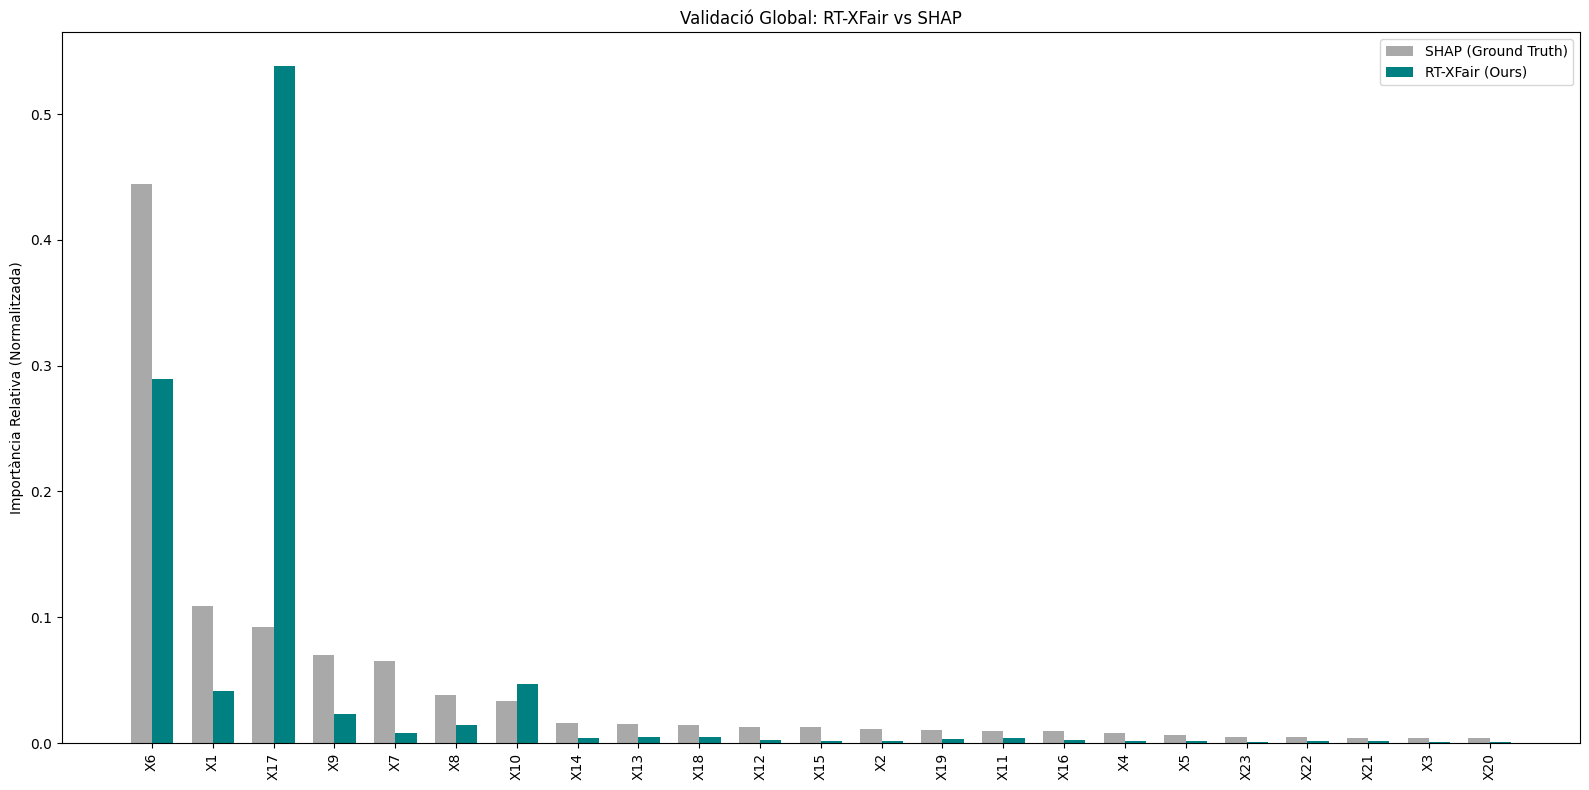

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import shap
import torch

def plot_global_validation(model, X_batch, explainer_shap, feature_names):
    print("Generant Gràfic de Validació Global...")
    
    # 1. RT-XFair (El teu model)
    X_tensor = torch.tensor(X_batch).float()
    # Assegura't que el model està en mode eval i beta està fixada
    model.eval()
    # model.beta ja hauria d'estar en 0.283 (del teu resultat òptim)
    
    _, explanations = model.explain(X_tensor)
    rt_global = torch.mean(torch.abs(explanations), dim=0).detach().numpy()
    
    # 2. SHAP (Ground Truth)
    shap_vals = explainer_shap.shap_values(X_batch, nsamples=100, silent=True)
    if isinstance(shap_vals, list): shap_vals = shap_vals[0]
    shap_vals = np.array(shap_vals)
    if len(shap_vals.shape) == 3: shap_vals = np.squeeze(shap_vals)
    shap_global = np.mean(np.abs(shap_vals), axis=0)
    
    # 3. Normalització (per comparar patrons, no escales)
    rt_norm = (rt_global / np.sum(rt_global)).flatten()
    shap_norm = (shap_global / np.sum(shap_global)).flatten()
    
    # 4. Ordenar per SHAP (de més a menys important)
    indices = np.argsort(shap_norm)[::-1] 
    sorted_names = np.array(feature_names)[indices]
    
    # 5. Plot
    x = np.arange(len(feature_names))
    width = 0.35
    
    plt.figure(figsize=(16, 8))
    plt.bar(x - width/2, shap_norm[indices], width, label='SHAP (Ground Truth)', color='#A9A9A9') # Gris
    plt.bar(x + width/2, rt_norm[indices], width, label='RT-XFair (Ours)', color='#008080') # Teal
    
    plt.ylabel('Importància Relativa (Normalitzada)')
    plt.title('Validació Global: RT-XFair vs SHAP')
    plt.xticks(x, sorted_names, rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Executa-ho amb 100 mostres del test
# Assegura't de passar X_test_scaled com a array numpy
features_list = list(X_raw.columns)
plot_global_validation(model, X_test_scaled, explainer, features_list)

Generant comparatives locals...


/Users/eloi.garcia/Library/Python/3.9/lib/python/site-packages/shap/explainers/_kernel.py:706: RuntimeWarning: divide by zero encountered in matmul
  w = np.linalg.solve(X.T @ WX, WX.T @ y)
/Users/eloi.garcia/Library/Python/3.9/lib/python/site-packages/shap/explainers/_kernel.py:706: RuntimeWarning: overflow encountered in matmul
  w = np.linalg.solve(X.T @ WX, WX.T @ y)
/Users/eloi.garcia/Library/Python/3.9/lib/python/site-packages/shap/explainers/_kernel.py:706: RuntimeWarning: invalid value encountered in matmul
  w = np.linalg.solve(X.T @ WX, WX.T @ y)
/Users/eloi.garcia/Library/Python/3.9/lib/python/site-packages/shap/explainers/_kernel.py:706: RuntimeWarning: divide by zero encountered in matmul
  w = np.linalg.solve(X.T @ WX, WX.T @ y)
/Users/eloi.garcia/Library/Python/3.9/lib/python/site-packages/shap/explainers/_kernel.py:706: RuntimeWarning: overflow encountered in matmul
  w = np.linalg.solve(X.T @ WX, WX.T @ y)
/Users/eloi.garcia/Library/Python/3.9/lib/python/site-packages/

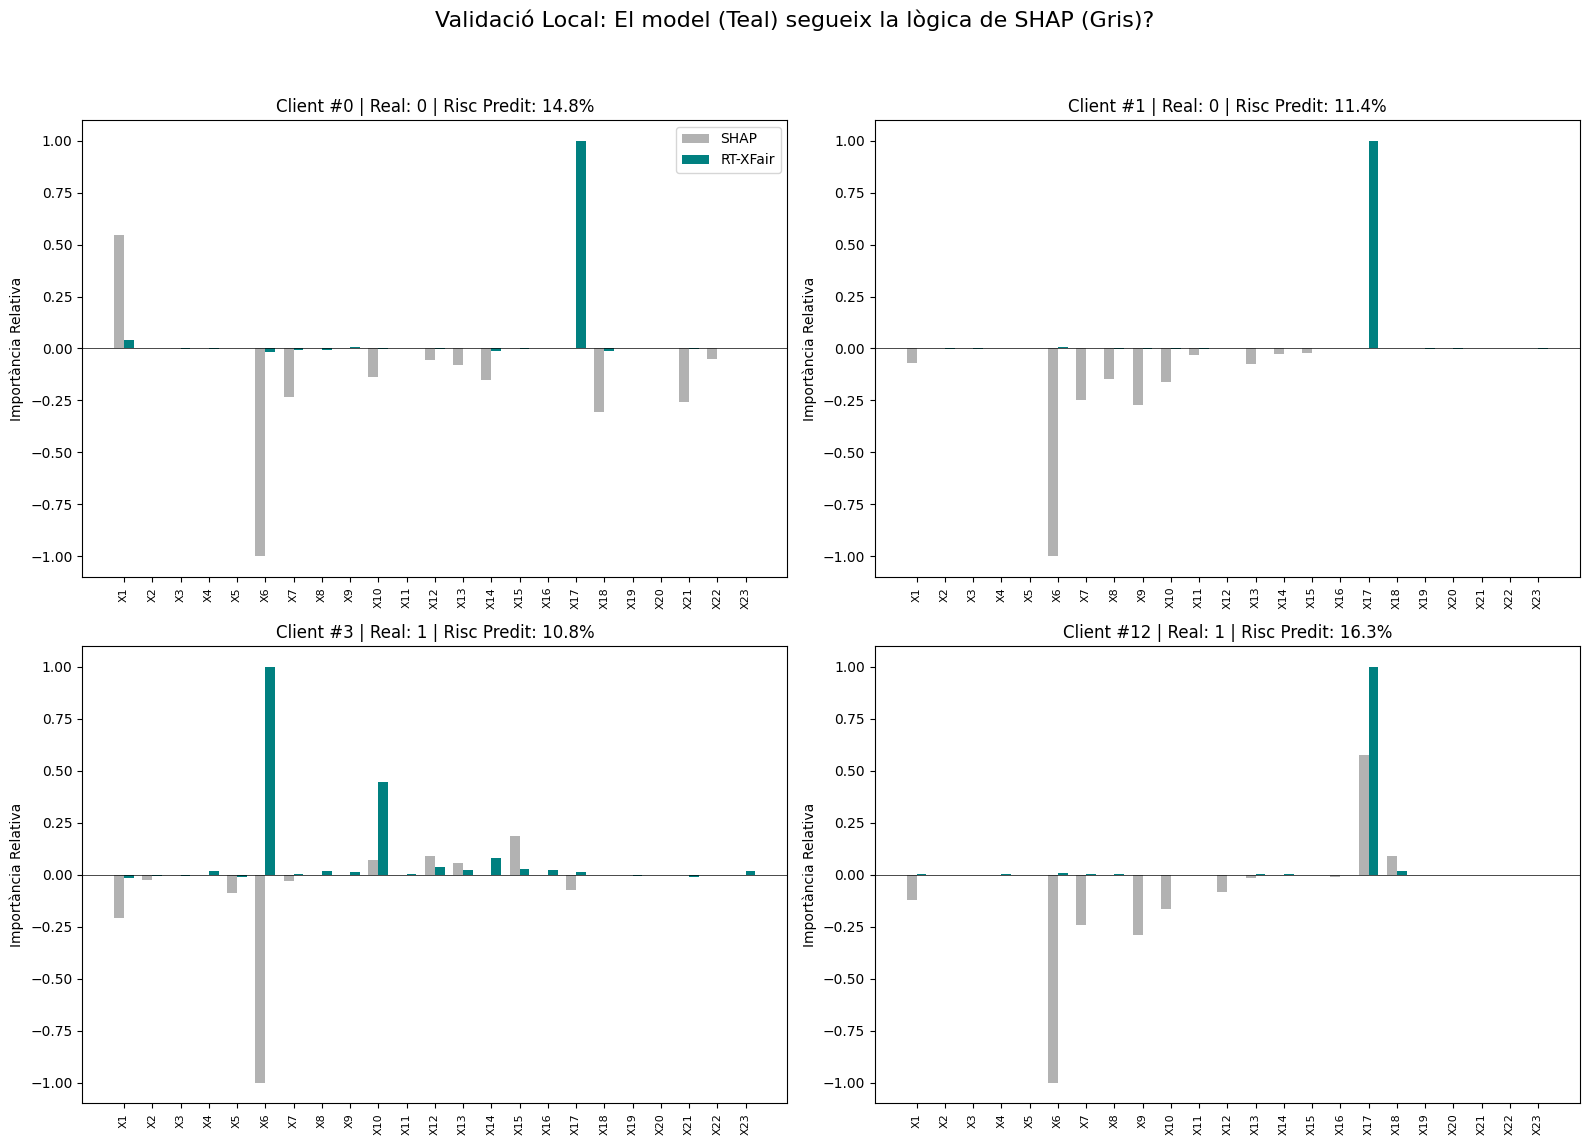

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Assegura't que el model està en mode avaluació
model.eval()

# 1. Selecció d'índexs (2 de cada classe)
indices_class_0 = np.where(y_test == 0)[0][:2]
indices_class_1 = np.where(y_test == 1)[0][:2]
selected_indices = np.concatenate([indices_class_0, indices_class_1])

feat_names = list(X_raw.columns)
x = np.arange(len(feat_names))
width = 0.35  # Amplada de les barres

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

print("Generant comparatives locals...")

for idx, sample_idx in enumerate(selected_indices):
    # A. Preparar inputs
    # Convertim a tensor per al model i mantenim numpy per a SHAP
    input_tensor = torch.tensor(X_test_scaled[sample_idx:sample_idx+1]).float()
    input_numpy = X_test_scaled[sample_idx:sample_idx+1]
    
    # B. Calcular RT-XFair (El teu model)
    pred, expl = model.explain(input_tensor)
    rt_vals = expl.detach().numpy().flatten()
    
    # C. Calcular SHAP (Ground Truth)
    # nsamples=100 és ràpid; per més precisió usa 1000
    shap_out = explainer.shap_values(input_numpy, nsamples=100, silent=True)
    if isinstance(shap_out, list): shap_vals = shap_out[0]
    else: shap_vals = shap_out
    shap_vals = shap_vals.flatten()
    
    # D. Normalització per a visualització (Important!)
    # Com que les magnituds poden ser diferents, normalitzem pel màxim absolut
    # per comparar el PATRÓ (quines pugen i quines baixen).
    rt_norm = rt_vals / (np.max(np.abs(rt_vals)) + 1e-9)
    shap_norm = shap_vals / (np.max(np.abs(shap_vals)) + 1e-9)
    
    # E. Plotting
    ax = axes[idx]
    true_label = int(y_test[sample_idx])
    
    # Barres SHAP (Esquerra)
    rects1 = ax.bar(x - width/2, shap_norm, width, label='SHAP', color='gray', alpha=0.6)
    # Barres RT-XFair (Dreta)
    rects2 = ax.bar(x + width/2, rt_norm, width, label='RT-XFair', color='teal')
    
    # Decoració
    ax.set_ylabel('Importància Relativa')
    ax.set_title(f"Client #{sample_idx} | Real: {true_label} | Risc Predit: {pred.item():.1%}")
    ax.set_xticks(x)
    ax.set_xticklabels(feat_names, rotation=90, fontsize=8)
    
    # Línia zero per referència
    ax.axhline(0, color='black', linewidth=0.5)
    
    # Llegenda només al primer gràfic per no embrutar
    if idx == 0:
        ax.legend()

plt.suptitle("Validació Local: El model (Teal) segueix la lògica de SHAP (Gris)?", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajustar per al títol superior
plt.show()


In [11]:
print("Generant artefacte TorchScript per a producció...")
example_input = torch.tensor(X_train_scaled[:1])
try:
    # Tracegem només el forward pass per a inferència d'alta velocitat
    traced_model = torch.jit.trace(model, example_input)
    traced_model.save("rtxfair_model_v1.pt")
    print("Model exportat: rtxfair_model_v1.pt")
except Exception as e:
    print(f"Error exportant: {e}")

Generant artefacte TorchScript per a producció...
Model exportat: rtxfair_model_v1.pt
